In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('cifar10-neural-network')
jovian.set_colab_id('1YRGzu9S7qHgsMs-zy-pdb3Vm3fwtfrz4')

     |████████████████████████████████| 71kB 7.4MB/s 


# cifar10-neural-network

Use the "Run" button to execute the code.

# Imports

In [2]:
import torch
import torch.nn as nn 
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
%matplotlib inline

In [30]:
import pandas as pd

In [3]:
project_name = '03_cifar_nn_model'

# Exploring CIFAR10 Dataset

In [4]:
dataset = CIFAR10(root='data/',download=True,transform=ToTensor())


Extracting data/cifar-10-python.tar.gz to data/


In [5]:
test_dataset = CIFAR10(root='data/',train=False,download=True,transform=ToTensor())

Files already downloaded and verified


In [6]:
dataset_size = len(dataset)
dataset_size

50000

In [7]:
test_dataset_size = len(test_dataset)
test_dataset_size

10000

In [8]:
print("Number of classes: ",len(dataset.classes))

Number of classes:  10


In [9]:
image, label = dataset[0]
img_shape = image.shape
img_shape

torch.Size([3, 32, 32])

In [10]:
classes = dataset.classes

frog


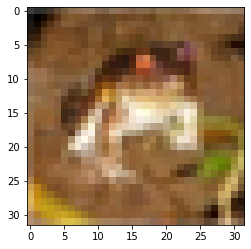

In [11]:
plt.imshow(image.permute(1,2,0))
print(classes[label])

In [12]:
class_label_img = {}
for img, label in dataset:
  if not class_label_img.get(label):
    class_label_img[label] = 1
  else:
    class_label_img[label] += 1

In [13]:
class_label_img

{0: 5000,
 1: 5000,
 2: 5000,
 3: 5000,
 4: 5000,
 5: 5000,
 6: 5000,
 7: 5000,
 8: 5000,
 9: 5000}

From the above result we can see that it is a balanced dataset with each class having 5000 images

### Commit

In [15]:
!pip install jovian --upgrade --quiet
import jovian
# Execute this to save new versions of the notebook
jovian.commit(project="cifar10-neural-network")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/developer-jnk/cifar10-neural-network


'https://jovian.ai/developer-jnk/cifar10-neural-network'

# Preparing Dataset

In [16]:
torch.manual_seed(42)
val_len = 5000
train_len = len(dataset) - val_len

In [17]:
train_ds, valid_ds = random_split(dataset, [train_len, val_len])
len(train_ds), len(valid_ds)

(45000, 5000)

Create batch dataloaders

In [18]:
batch_size = 128

In [19]:
train_loader = DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
valid_loader = DataLoader(valid_ds,batch_size*2,num_workers=4,pin_memory=True)
test_loader = DataLoader(test_dataset,batch_size*2,num_workers=4,pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Image shape : torch.Size([128, 3, 32, 32])


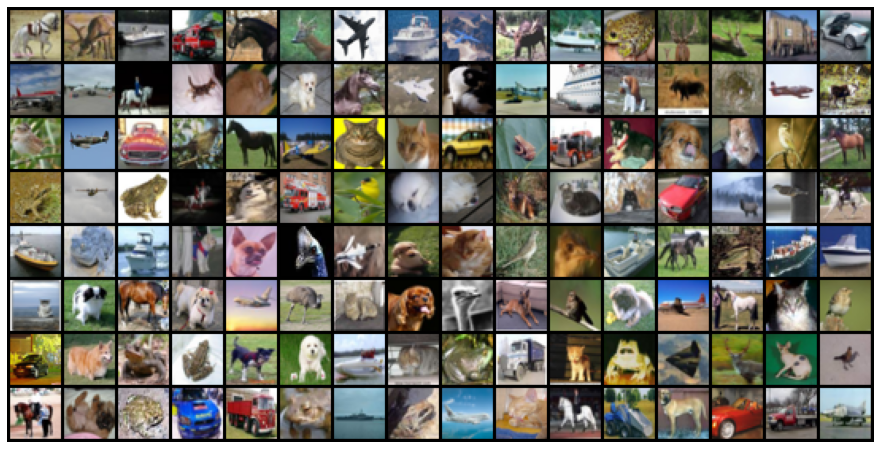

In [20]:
for images, _ in train_loader:
  print('Image shape :',images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images,nrow=16).permute(1,2,0))
  plt.show()
  break

# Base Model class and Training on GPU

Let's define the basic metric and classification baselione model

In [21]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / preds.numel())

In [37]:
class ImageClassificationBaseModel(nn.Module):

  def training_step(self,batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss':loss,'val_acc':acc}

  def calculate_epoch_end(self,val_outputs, train_outputs):
    val_batch_losses = [x['val_loss'] for x in val_outputs]
    val_epoch_loss = torch.stack(val_batch_losses).mean()
    val_batch_acc = [x['val_acc'] for x in val_outputs]
    val_epoch_acc = torch.stack(val_batch_acc).mean()

    train_batch_losses = [x['val_loss'] for x in train_outputs]
    train_epoch_loss = torch.stack(train_batch_losses).mean()
    train_batch_acc = [x['val_acc'] for x in train_outputs]
    train_epoch_acc = torch.stack(train_batch_acc).mean()

    return {'train_loss':train_epoch_loss,'train_acc':train_epoch_acc,'val_loss':val_epoch_loss,'val_acc':val_epoch_acc}

  def epoch_end(self,epoch,num_epochs,results):
    print("Epoch [{}/{}] : train_acc:{:.4f}, train_loss:{:.4f} val_acc:{:.4f}, val_loss:{:.4f}".format(epoch,num_epochs,results['train_acc'],results['train_loss'],results['val_acc'],results['val_loss']))

In [22]:
def evaluate(model, val_loader, train_loader):
  val_outputs = [model.validation_step(batch) for batch in val_loader]
  train_outputs = [model.validation_step(batch) for batch in train_loader]
  return model.calculate_epoch_end(val_outputs, train_outputs)

In [24]:
def fit(epochs, lr, model, train_dl, valid_dl, opt = torch.optim.SGD):

  optimizer = opt(model.parameters(), lr)
  history = []

  for epoch in range(epochs):

    # training step
    for batch in train_dl:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    results = evaluate(model,valid_dl,train_dl)
    model.epoch_end(epoch, epochs, results)
    history.append(results)

  return history

In [25]:
torch.cuda.is_available()

True

In [26]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return roech.device('cpu')

In [27]:
device = get_default_device()
device

device(type='cuda')

In [28]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [29]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [31]:
train_loader = DeviceDataLoader(train_loader,device)
valid_loader = DeviceDataLoader(valid_loader,device)
test_loader = DeviceDataLoader(test_loader,device)

# Training the model

In [32]:
input_shape = 3*32*32
output_size = 10

Extend ImageClassificationBaseModel 

In [38]:
class Cifar10Model(ImageClassificationBaseModel):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(input_shape, 128)
    self.layer2 = nn.Linear(128,128)
    self.layer3 = nn.Linear(128,64)
    self.layer4 = nn.Linear(64,output_size)

  def forward(self,xb):
    #flatten
    out = xb.view(xb.size(0),-1)
    # layer 1 -intermediate op
    out = self.layer1(out)
    # Non-linearity
    out = F.relu(out)
    # layer 2 -intermediate op
    out = self.layer2(out)
    # Non-linearity
    out = F.relu(out)
    # layer 3 -intermediate op
    out = self.layer3(out)
    # Non-linearity
    out = F.relu(out)
    # layer 4 -final op
    out = self.layer4(out)
    # Non-linear
    out = F.sigmoid(out)
    
    return out


In [39]:
model = to_device(Cifar10Model(), device)

Evaluate Before training 

In [40]:
history = [evaluate(model,valid_loader, train_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[{'train_acc': tensor(0.1027),
  'train_loss': tensor(2.3028, device='cuda:0', grad_fn=<MeanBackward0>),
  'val_acc': tensor(0.1009),
  'val_loss': tensor(2.3026, device='cuda:0', grad_fn=<MeanBackward0>)}]

We can see it has 10% accuracy before model training

In [41]:
history += fit(5, 0.001, model, train_loader, valid_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [0/5] : train_acc:0.1106, train_loss:2.3027 val_acc:0.1109, val_loss:2.3025
Epoch [1/5] : train_acc:0.1201, train_loss:2.3026 val_acc:0.1185, val_loss:2.3024
Epoch [2/5] : train_acc:0.1262, train_loss:2.3024 val_acc:0.1268, val_loss:2.3023
Epoch [3/5] : train_acc:0.1290, train_loss:2.3023 val_acc:0.1264, val_loss:2.3022
Epoch [4/5] : train_acc:0.1289, train_loss:2.3022 val_acc:0.1244, val_loss:2.3021


In [42]:
history += fit(20, 0.01, model, train_loader, valid_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [0/20] : train_acc:0.1080, train_loss:2.3013 val_acc:0.1065, val_loss:2.3012
Epoch [1/20] : train_acc:0.1011, train_loss:2.3002 val_acc:0.0991, val_loss:2.3002
Epoch [2/20] : train_acc:0.1001, train_loss:2.2986 val_acc:0.0978, val_loss:2.2987
Epoch [3/20] : train_acc:0.1014, train_loss:2.2960 val_acc:0.0992, val_loss:2.2962
Epoch [4/20] : train_acc:0.1144, train_loss:2.2915 val_acc:0.1126, val_loss:2.2919
Epoch [5/20] : train_acc:0.1320, train_loss:2.2835 val_acc:0.1274, val_loss:2.2842
Epoch [6/20] : train_acc:0.1495, train_loss:2.2688 val_acc:0.1459, val_loss:2.2700
Epoch [7/20] : train_acc:0.1626, train_loss:2.2414 val_acc:0.1618, val_loss:2.2436
Epoch [8/20] : train_acc:0.1693, train_loss:2.2016 val_acc:0.1655, val_loss:2.2055
Epoch [9/20] : train_acc:0.1586, train_loss:2.1696 val_acc:0.1614, val_loss:2.1748
Epoch [10/20] : train_acc:0.1618, train_loss:2.1507 val_acc:0.1667, val_loss:2.1570
Epoch [11/20] : train_acc:0.1640, train_loss:2.1390 val_acc:0.1684, val_loss:2.1461


RuntimeError: ignored

In [ ]:
history += fit(20, 0.01, model, train_loader, valid_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


RuntimeError: ignored

In [ ]:
history += fit(20, 0.001, model, train_loader, valid_loader)

In [ ]:
history += fit(20, 0.01, model, train_loader, valid_loader)

In [ ]:
plot_losses(history)

In [ ]:
plot_accuracies(history)

In [ ]:
evaluate(model, test_loader)

# Saving results

In [ ]:
torch.save(model.state_dict(),'cifar10-feed-forward.pth')

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="cifar10-neural-network")